# Modelo 2 Arvore de Decisão

## 1. Instalação e Imports
Instala a biblioteca SHAP para análise de interpretabilidade do modelo.



In [ ]:
!pip install shap

import pandas as pd
import numpy as np
import shap
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


## 2. Configurações Iniciais

Configurações para melhor visualização de DataFrames e estilo de gráficos.

In [ ]:
# Configurações
pd.set_option('display.max_columns', 50)
plt.style.use('ggplot')


## 3. Carregamento e Preparação dos Dados

In [ ]:
# 1. Carregar dados
df = pd.read_csv('dados_selecionados.csv')

# Variável target
tech_cols = ['python', 'aws', 'azure', 'gcp', 'powerbi', 'tableau']
df[tech_cols] = df[tech_cols].astype(bool)

conditions = (
    df['python'] &
    (df['aws'] | df['azure'] | df['gcp']) &
    (df['powerbi'] | df['tableau'])
)
df['target_ia_generativa'] = np.where(conditions, 1, 0)


## 4. Engenharia de Features

In [ ]:

# 2. Features seguras
features_seguras = [
    'sql', 'r', 'c_cpp_csharp', 'dotnet', 'java', 'javascript',
    'postgresql', 'bigquery', 'snowflake', 'databricks',
    'looker_studio', 'excel_planilhas', 'exp_dados', 'exp_ti'
]

# 3. Engenharia de features
df['total_linguagens'] = df[['sql', 'r', 'c_cpp_csharp', 'java', 'javascript']].sum(axis=1)
df['exp_total'] = df['exp_dados'] + df['exp_ti']
features_seguras.extend(['total_linguagens', 'exp_total'])

## 5. Pré-processamento

In [ ]:

# 4. Pré-processamento
for col in features_seguras:
    if df[col].dtype == 'object':
        df[col] = df[col].map({'Sim': 1, 'Não': 0}).fillna(0).astype(int)

exp_map = {
    'Menos de 1 ano': 0.5,
    'de 1 a 2 anos': 1.5,
    'de 3 a 4 anos': 3.5,
    'de 5 a 6 anos': 5.5,
    'de 7 a 10 anos': 8.5,
    'Mais de 10 anos': 11
}
df['exp_dados'] = df['exp_dados'].astype(str).map(exp_map).fillna(0)
df['exp_ti'] = df['exp_ti'].astype(str).map(exp_map).fillna(0)

numeric_features = features_seguras.copy()

# Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['nivel_ensino']),
        ('num', StandardScaler(), numeric_features)
    ]
)


## 6. Modelagem com Árvore de Decisão

In [ ]:
#5. Modelagem com Árvore de Decisão
X = df[features_seguras + ['nivel_ensino']]
y = df['target_ia_generativa']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

params = {
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    pipeline,
    params,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)



## 7. Avaliação, Elementos de Visualização

## 8. Análise SHAP

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Melhores parâmetros: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_split': 10}
Acurácia Treino: 77.10%
Acurácia Teste:  73.94%

Relatório de Classificação (Teste):
              precision    recall  f1-score   support

           0       0.64      0.82      0.71       530
           1       0.85      0.69      0.76       794

    accuracy                           0.74      1324
   macro avg       0.74      0.75      0.74      1324
weighted avg       0.76      0.74      0.74      1324



<Figure size 800x600 with 0 Axes>

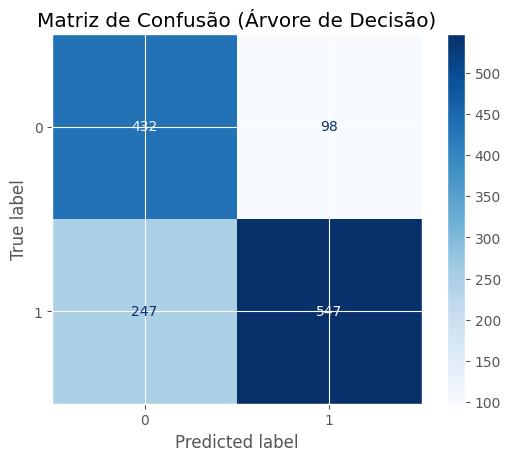

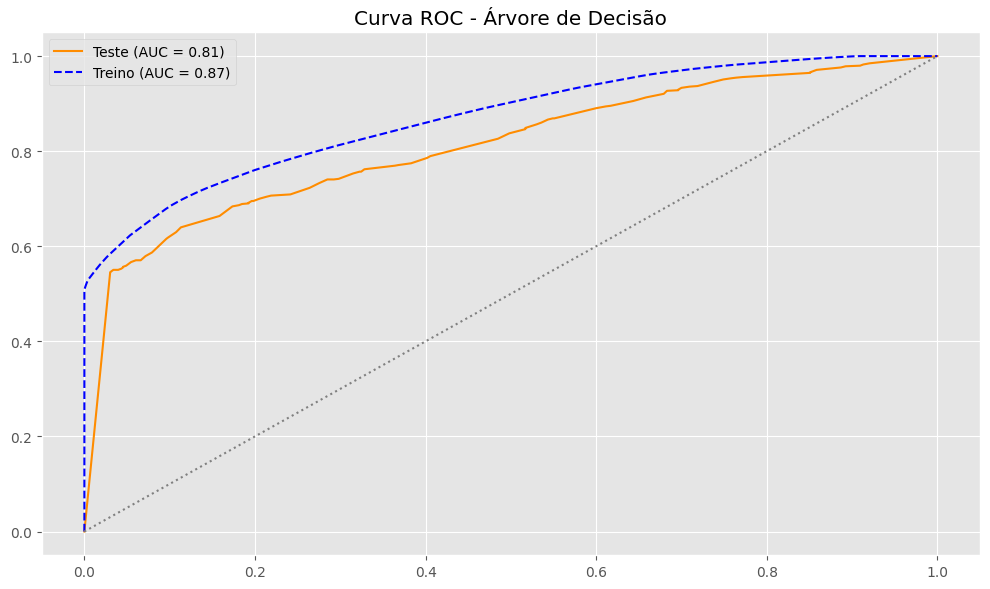

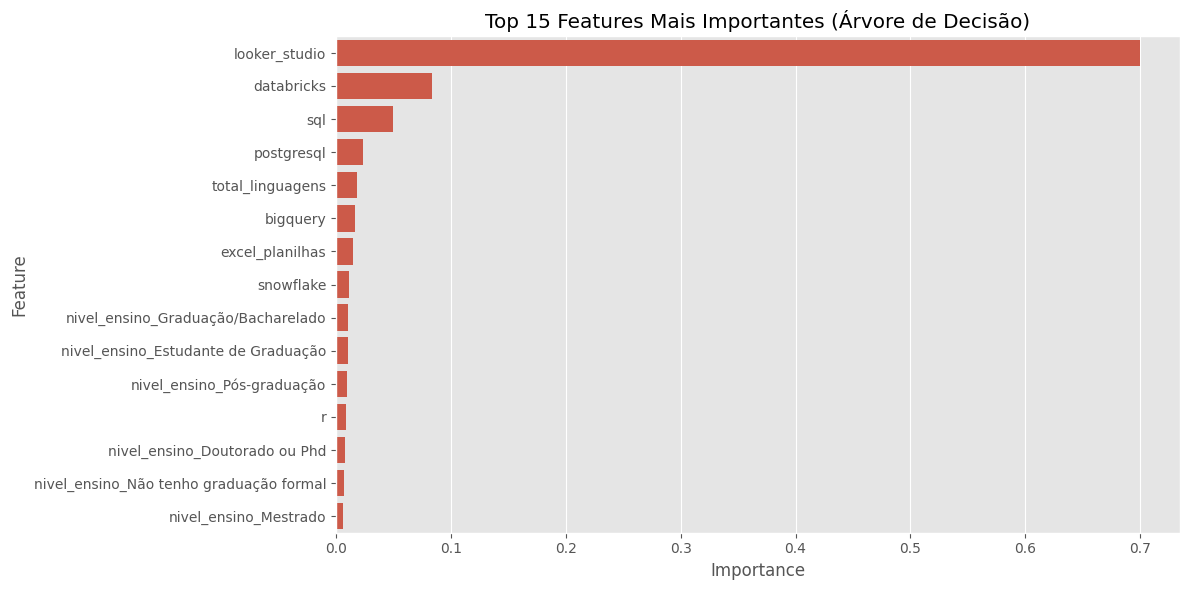

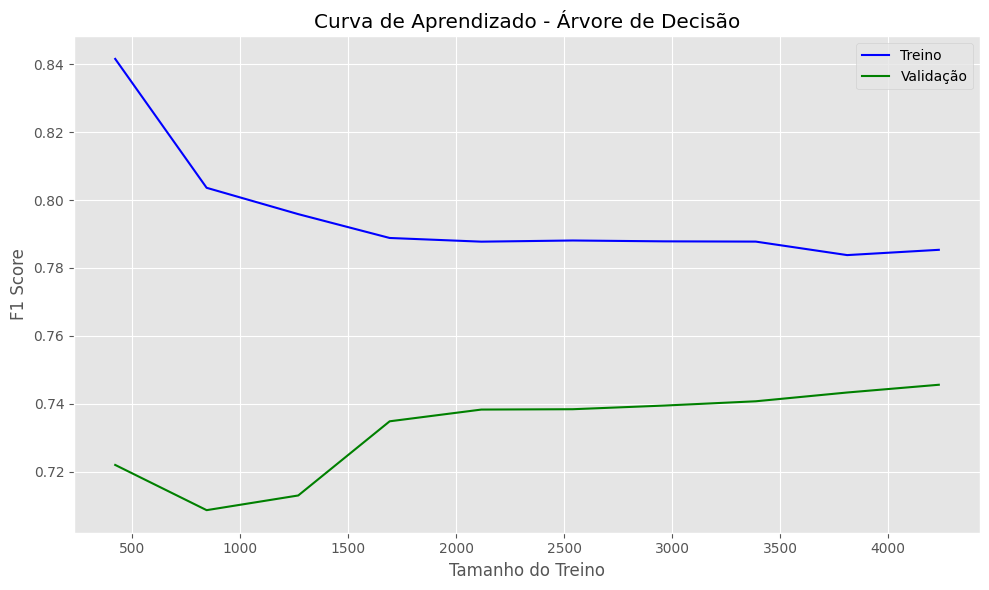

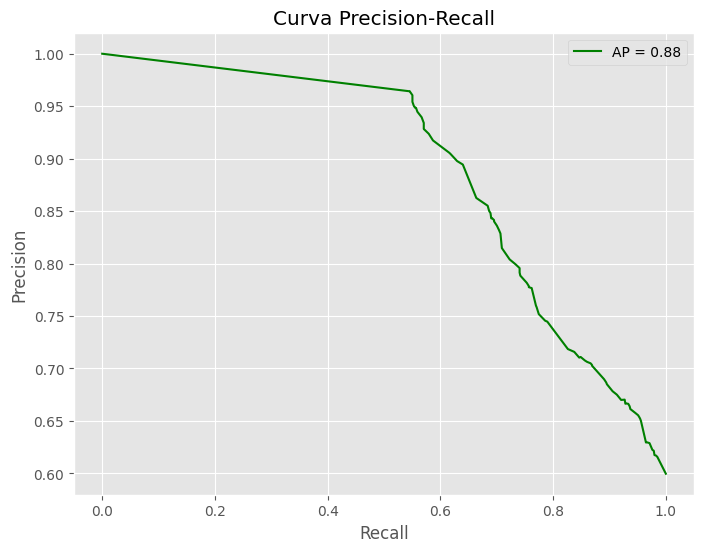

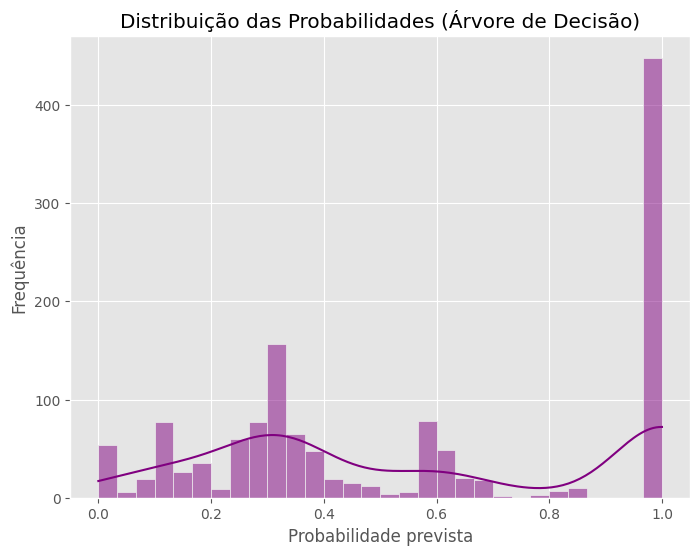

<Figure size 640x480 with 0 Axes>

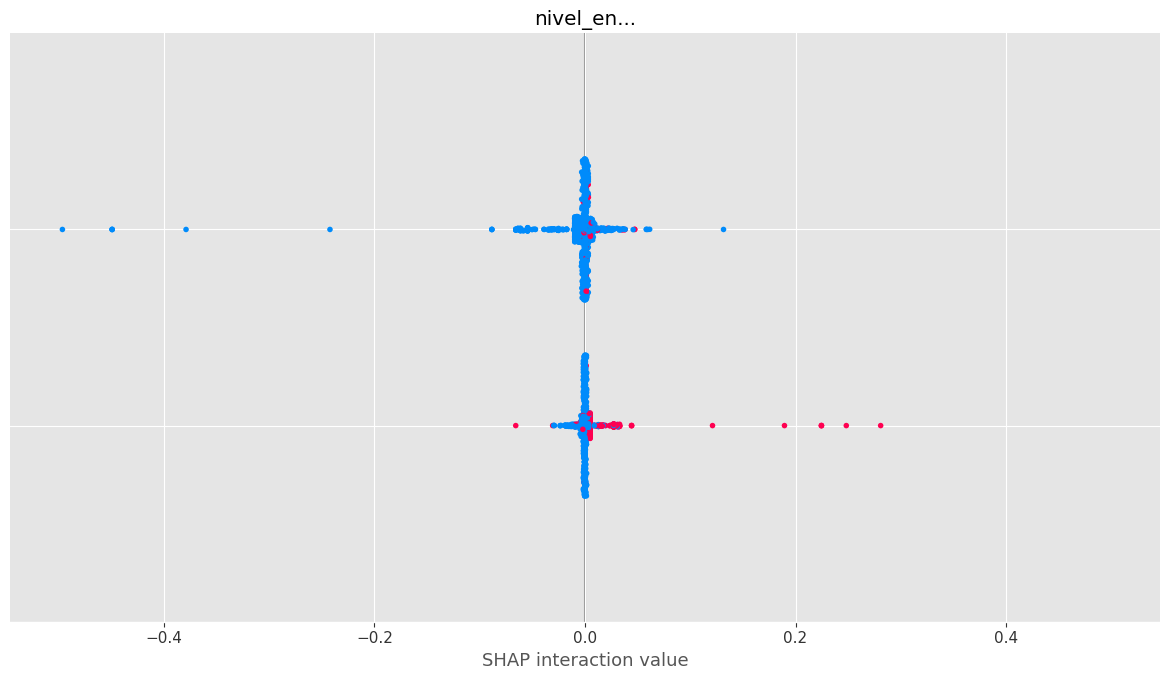

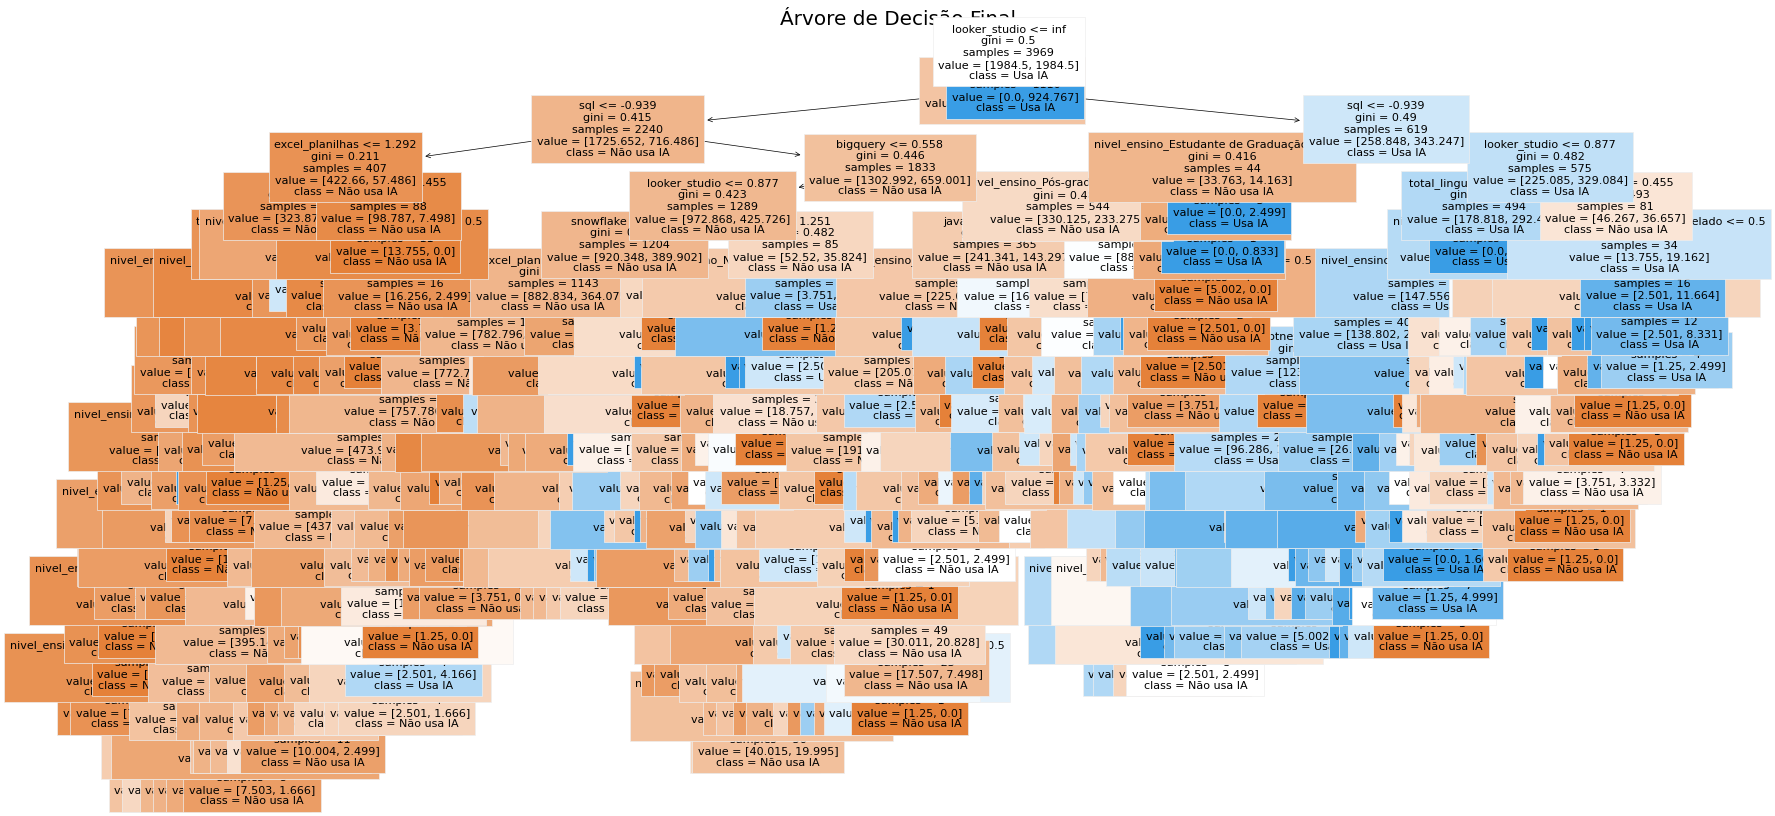

In [1]:

#
# 6. Avaliação
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)
y_proba_test = best_model.predict_proba(X_test)[:, 1]
y_proba_train = best_model.predict_proba(X_train)[:, 1]

print("\nMelhores parâmetros:", grid_search.best_params_)
print(f"Acurácia Treino: {accuracy_score(y_train, y_pred_train):.2%}")
print(f"Acurácia Teste:  {accuracy_score(y_test, y_pred_test):.2%}")

with open("best_params_arvore.json", "w") as f:
    json.dump(grid_search.best_params_, f, indent=4)

relatorio = classification_report(y_test, y_pred_test)
print("\nRelatório de Classificação (Teste):")
print(relatorio)
with open("classification_report_arvore.txt", "w") as f:
    f.write(relatorio)

# Matriz de Confusão
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title('Matriz de Confusão (Árvore de Decisão)')
plt.savefig("matriz_confusao_arvore.png", dpi=300)
plt.show()

# Curva ROC
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Teste (AUC = {roc_auc_test:.2f})', color='darkorange')
plt.plot(fpr_train, tpr_train, label=f'Treino (AUC = {roc_auc_train:.2f})', color='blue', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle=':', color='gray')
plt.title('Curva ROC - Árvore de Decisão')
plt.legend()
plt.tight_layout()
plt.savefig("roc_arvore.png", dpi=300)
plt.show()

# Importância das Features
feature_names = (
    list(best_model.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(['nivel_ensino'])) +
    numeric_features
)
importances = best_model.named_steps['classifier'].feature_importances_
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Top 15 Features Mais Importantes (Árvore de Decisão)')
plt.tight_layout()
plt.savefig("importancia_arvore.png", dpi=300)
plt.show()

# Curva de Aprendizado
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X, y,
    cv=5,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Treino', color='blue')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validação', color='green')
plt.title('Curva de Aprendizado - Árvore de Decisão')
plt.xlabel('Tamanho do Treino')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("curva_aprendizado_arvore.png", dpi=300)
plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
avg_precision = average_precision_score(y_test, y_proba_test)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()

# Distribuição de probabilidades
plt.figure(figsize=(8,6))
sns.histplot(y_proba_test, bins=30, kde=True, color='purple')
plt.title('Distribuição das Probabilidades (Árvore de Decisão)')
plt.xlabel('Probabilidade prevista')
plt.ylabel('Frequência')
plt.show()

# SHAP
X_transformed = best_model.named_steps['preprocessor'].transform(X_test)
explainer = shap.Explainer(best_model.named_steps['classifier'])
shap_values = explainer(X_transformed)

shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)

# Visualizar árvore
plt.figure(figsize=(20, 10))
plot_tree(
    best_model.named_steps['classifier'],
    feature_names=feature_names,
    class_names=['Não usa IA', 'Usa IA'],
    filled=True,
    fontsize=8
)
plt.title("Árvore de Decisão Final")
plt.savefig("arvore_visual.png", dpi=300)
plt.show()